 ## CPES SMR Attack graph quantification

# Define the attack graph structure


# set up terminal attack leaf node weights 
Each terminal node gets a random value from a Beta distribution

In [90]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define attack graph structure
attack_graph = {
    "L4": ["L4.1", "L4.2"],
    "L4.1": ["L4.1.1", "L4.1.2"],
    "L4.1.1": ["L4.1.1.1", "L4.1.1.2"],
    "L4.1.2": ["L4.1.2.1", "L4.1.2.2"],
    "L4.2": ["L4.2.1", "L4.2.2"],
    "L4.2.1": ["L4.2.1.1", "L4.2.1.2"],
    "L4.2.2": ["L4.2.2.1", "L4.2.2.2"],
    "L4.2.2.1": ["L4.2.2.1.1", "L4.2.2.1.2"],
    "L4.2.2.2": ["L4.2.2.2.1", "L4.2.2.2.2"]
}



In [91]:
# Step 2: Create directed graph
G = nx.DiGraph()
for parent, children in attack_graph.items():
    for child in children:
        G.add_edge(child, parent)  # bottom-up (leaf → root)

# Step 3: Identify terminal (leaf) nodes
terminal_nodes = [n for n in G.nodes() if G.out_degree(n) == 0]

# Step 4: Define beta distribution parameters
beta_params = {node: (3, 5) for node in terminal_nodes}
use_beta = True  # Toggle to switch distributions



In [92]:
# Boolean logic operator of the child nodes
node_logic = {
    "L4": "OR",
    "L4.1": "OR",
    "L4.2": "OR",
    "L4.1.1": "AND",
    "L4.1.2": "AND",
    "L4.2.1": "AND",
    "L4.2.2": "AND",
    "L4.2.2.1": "OR",
    "L4.2.2.2": "OR",
    # All others not listed will default to AND
}


In [93]:
# Step 5: Initialize logical weights for terminal nodes using Beta(3,5)
initial_logical_weights = {
    node: np.random.beta(*beta_params[node]) for node in terminal_nodes
}


# Step 6: Compute Logical Weights



In [94]:
def compute_logical_weight(G, initial_weights, beta_params):
    logical_weights = {}

    def helper(node):
        if node in logical_weights:
            return logical_weights[node]

        if G.in_degree(node) == 0:  # Terminal node
            logical_weights[node] = initial_weights.get(node, np.random.beta(*beta_params.get(node, (3, 5))))
            return logical_weights[node]

        parents = list(G.predecessors(node))
        valid_parents = [helper(p) for p in parents if p in G.nodes()]
        logic = node_logic.get(node, "AND")
        if valid_parents:
            if logic == "AND":
                logical_weights[node] = min(valid_parents)
            elif logic == "OR":
                logical_weights[node] = max(valid_parents)
        else:
            logical_weights[node] = 0

        return logical_weights[node]

    for node in G.nodes():
        helper(node)

    return logical_weights



In [95]:
# Step 6: Run the model
LW_results = compute_logical_weight(G, initial_logical_weights, beta_params)



In [96]:
G.in_degree

InDegreeView({'L4.1': 2, 'L4': 2, 'L4.2': 2, 'L4.1.1': 2, 'L4.1.2': 2, 'L4.1.1.1': 0, 'L4.1.1.2': 0, 'L4.1.2.1': 0, 'L4.1.2.2': 0, 'L4.2.1': 2, 'L4.2.2': 2, 'L4.2.1.1': 0, 'L4.2.1.2': 0, 'L4.2.2.1': 2, 'L4.2.2.2': 2, 'L4.2.2.1.1': 0, 'L4.2.2.1.2': 0, 'L4.2.2.2.1': 0, 'L4.2.2.2.2': 0})


Logical Weights for Attack Nodes:
L4.1.1.1: 0.118
L4.1.1.2: 0.385
L4.1.1: 0.118
L4.1.2.1: 0.510
L4.1.2.2: 0.466
L4.1.2: 0.466
L4.1: 0.466
L4.2.1.1: 0.282
L4.2.1.2: 0.271
L4.2.1: 0.271
L4.2.2.1.1: 0.112
L4.2.2.1.2: 0.268
L4.2.2.1: 0.268
L4.2.2.2.1: 0.460
L4.2.2.2.2: 0.246
L4.2.2.2: 0.460
L4.2.2: 0.268
L4.2: 0.271
L4: 0.466


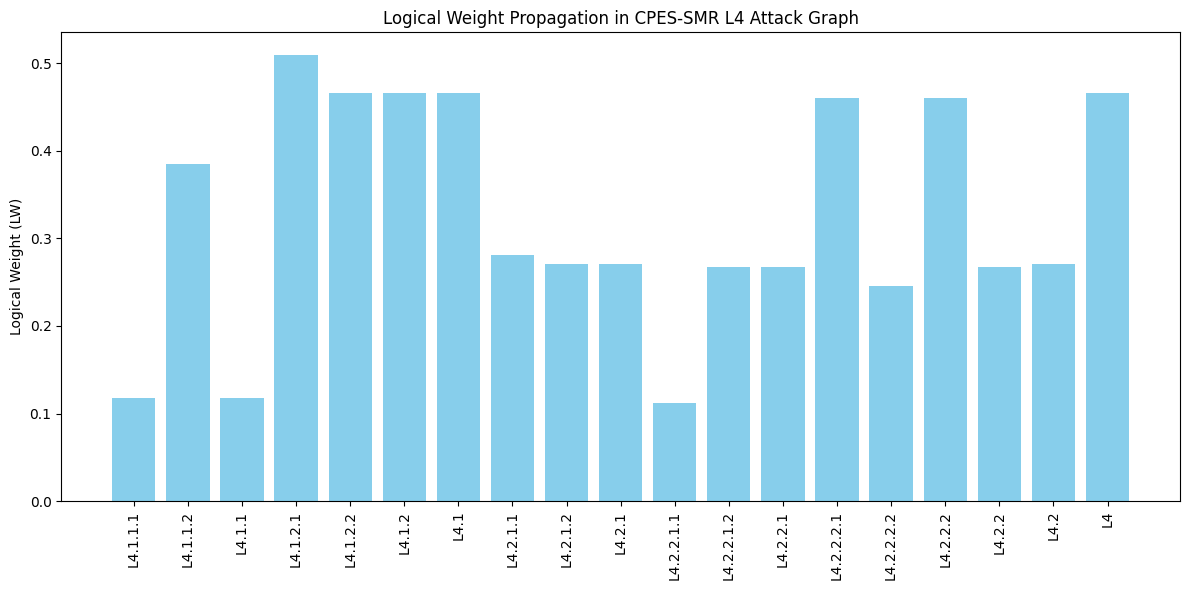

In [97]:
# Step 7: Print results
print("\nLogical Weights for Attack Nodes:")
for node, lw in LW_results.items():
    print(f"{node}: {lw:.3f}")

# Step 8: Visualize results
plt.figure(figsize=(12, 6))
plt.bar(LW_results.keys(), LW_results.values(), color="skyblue")
plt.xticks(rotation=90)
plt.ylabel("Logical Weight (LW)")
plt.title("Logical Weight Propagation in CPES-SMR L4 Attack Graph")
plt.tight_layout()
plt.show()

## Imapct score computation 

In [98]:
# Step 9: Variable Selection Method (Impact Score)
def compute_impact_scores_fixed_leaves(G, original_LW, node_logic):
    baseline = original_LW.get("L4", 0)
    impact_scores = {}

    terminal_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]

    for node in G.nodes():
        if node == "L4":
            continue

        G_temp = G.copy()
        if node in G_temp:
            G_temp.remove_node(node)

        # Reuse terminal weights from LW_results (fixed)
        temp_weights = {
            n: original_LW[n] for n in terminal_nodes if n != node and n in G_temp
        }

        # Re-propagate non-terminal nodes using AND/OR logic
        def propagate(G, weights):
            for n in nx.topological_sort(G):
                if n not in weights:
                    parents = list(G.predecessors(n))
                    valid_parents = [weights[p] for p in parents if p in weights]
                    logic = node_logic.get(n, "AND")
                    if valid_parents:
                        if logic == "AND":
                            weights[n] = min(valid_parents)
                        elif logic == "OR":
                            weights[n] = max(valid_parents)
                    else:
                        weights[n] = 0
            return weights

        temp_weights = propagate(G_temp, temp_weights)
        new_score = temp_weights.get("L4", 0)
        impact_scores[node] = baseline - new_score

    return impact_scores

In [99]:
impact_scores = compute_impact_scores_fixed_leaves(G, LW_results, node_logic)
sorted_impact = sorted(impact_scores.items(), key=lambda x: -x[1])

print("\nTop Critical Nodes (Fixed Leaf Weights):")
for node, score in sorted_impact[:10]:
    print(f"{node}: {score:.3f}")




Top Critical Nodes (Fixed Leaf Weights):
L4.1: 0.195
L4.1.2: 0.195
L4.2: 0.000
L4.1.1: 0.000
L4.1.1.1: 0.000
L4.1.1.2: 0.000
L4.1.2.1: 0.000
L4.2.1: 0.000
L4.2.2: 0.000
L4.2.1.1: 0.000


#Uniform logical weight of attack surface 
We want to now set all the terminal leaf attack nodes to the same logical weight to see the impact score changes 


In [100]:
initial_logical_weights = {node: 0.5 for node in terminal_nodes}


In [101]:
LW_results = compute_logical_weight(G, initial_logical_weights, beta_params)

In [102]:
impact_scores = compute_impact_scores_fixed_leaves(G, LW_results, node_logic)
sorted_impact = sorted(impact_scores.items(), key=lambda x: -x[1])

print("\nTop Critical Nodes (Fixed Leaf Weights):")
for node, score in sorted_impact[:10]:
    print(f"{node}: {score:.3f}")




Top Critical Nodes (Fixed Leaf Weights):
L4.2: 0.232
L4.2.2: 0.131
L4.2.2.2.2: 0.045
L4.1: 0.000
L4.1.1: 0.000
L4.1.2: 0.000
L4.1.1.2: 0.000
L4.1.2.1: 0.000
L4.1.2.2: 0.000
L4.2.1: 0.000
